# MUTATION CALLER COMPARISON in SARCOMA-lung sample

In [1]:
# Needed basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib_venn import venn3

# 1/ Importing filtered mutation tables

In [2]:
import pandas as pd

# Import filtered mutation files 
mutect_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Mutect2_VAF.tsv.gz', sep="\t", header=0)
strelka_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_VAF_all.tsv.gz', sep="\t", header=0)
sage_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_SAGE_VAF.tsv.gz', sep="\t", header=0)

In [3]:
mutect_df.shape + strelka_df.shape + sage_df.shape

(23011, 22, 24072, 20, 20454, 22)

In [4]:
sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_AF,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type,SAMPLE
0,chr1,104188,.,C,A,764,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:197,0:0:197:6097,0:206,0:0,0,0,0,0,197,1...",...,0.0,217,197,163,197,54,0,0.249,SNV,sarcoma-lung
1,chr1,843320,.,G,A,2303,PASS,LPS=1;LPS_RC=4;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:125,0:0:125:3974,0:127,0:0,0,0,0,0,125,1...",...,0.0,107,125,27,125,80,0,0.748,SNV,sarcoma-lung
2,chr1,1118520,.,C,T,813,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:148,0:0:148:4278,0:155,0:0,0,0,0,0,148,1...",...,0.0,133,148,92,148,41,0,0.308,SNV,sarcoma-lung
3,chr1,1136548,.,G,T,1894,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:124,0:0:124:3979,0:128,0:0,0,0,0,0,124,1...",...,0.0,122,124,41,124,81,0,0.664,SNV,sarcoma-lung
4,chr1,1182738,.,C,T,898,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:159,0:0:159:4649,0:173,0:0,0,0,0,0,159,1...",...,0.0,130,159,80,159,50,0,0.385,SNV,sarcoma-lung


## a) Find the number of common mutations with the callers

In [5]:
#Add a new column in mutect/strelka tables joining the CHROM-POS-REF-ALT information and extract it as a list

mutect_df['mut'] = mutect_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
m_list = mutect_df['mut'].tolist()

strelka_df['mut'] = strelka_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
s_list = strelka_df['mut'].tolist()

sage_df['mut'] = sage_df.apply(lambda row: row['CHROM']+'_'+str(row['POS'])+'_'+row['REF']+'_'+row['ALT'],axis=1)
sage_list = sage_df['mut'].tolist()

# Convert to a set function to obtain a unique collection of elements
set_m = set(m_list)
set_s = set(s_list)
set_sage = set(sage_list)

In [6]:
# Check if number of mutations coincides with previous data
# len(set_m)
# len(set_s)
len(set_sage)

20454

Text(0.5, 1.0, 'Sarcoma mutations in lung')

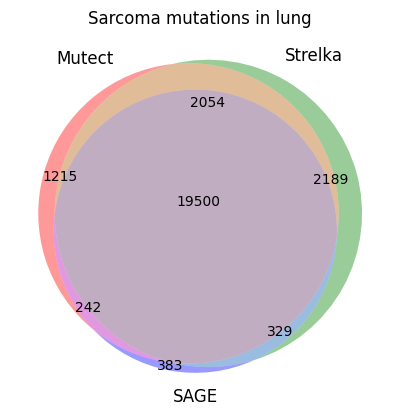

In [7]:
venn3([set_m,set_s, set_sage],set_labels=['Mutect','Strelka','SAGE'])
plt.title('Sarcoma mutations in lung')

# Sum numbers specific of each circle to check if the dimensions plotted agree with the number of mutations of each caller

## b) Obtain the list of mutations in a minimum of 2 callers

In [8]:
# Now merge based on "mut" column, in two-by-two comparisons since we want the common mutations in a minimum of two callers (how=inner)
mutstr_common_df = pd.merge(mutect_df, strelka_df, how ="inner", on=['mut'], suffixes=['_Mut','_Str'], indicator = True)
mutsage_common_df = pd.merge(mutect_df, sage_df, how ="inner", on=['mut'], suffixes=['_Mut','_SAGE'], indicator = True)
strsage_common_df = pd.merge(strelka_df, sage_df, how ="inner", on=['mut'], suffixes=['_Str','_SAGE'], indicator = True)

# Now we have the common mutations between callers.
# Since we priorize information from SAGE > Mutect2 callers, we will delete all information from the caller (Strelka information is not considered in any case)
mutstr_common_df = mutstr_common_df.loc[:, ~mutstr_common_df.columns.str.endswith('_Str')] # here we delete columns from Strelka and remain Mutect2 columns
mutsage_common_df = mutsage_common_df.loc[:, ~mutsage_common_df.columns.str.endswith('_Mut')] # here we delete columns from mutect and remain SAGE columns
strsage_common_df = strsage_common_df.loc[:, ~strsage_common_df.columns.str.endswith('_Str')] # here we delete columns from Strelka and remain SAGE columns

In [9]:
strsage_common_df

,Mut_type,mut,CHROM_SAGE,POS_SAGE,ID_SAGE,REF_SAGE,ALT_SAGE,QUAL_SAGE,FILTER_SAGE,INFO_SAGE,...,t_DP_SAGE,n_DP_SAGE,t_ref_reads_SAGE,n_ref_reads_SAGE,t_alt_reads_SAGE,n_alt_reads_SAGE,VAF_SAGE,mut_type,SAMPLE_SAGE,_merge
0,SNV,chr1_104188_C_A,chr1,104188,.,C,A,764,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,...,217,197,163,197,54,0,0.249,SNV,sarcoma-lung,both
1,SNV,chr1_843320_G_A,chr1,843320,.,G,A,2303,PASS,LPS=1;LPS_RC=4;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,...,107,125,27,125,80,0,0.748,SNV,sarcoma-lung,both
2,SNV,chr1_1118520_C_T,chr1,1118520,.,C,T,813,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,...,133,148,92,148,41,0,0.308,SNV,sarcoma-lung,both
3,SNV,chr1_1136548_G_T,chr1,1136548,.,G,T,1894,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,...,122,124,41,124,81,0,0.664,SNV,sarcoma-lung,both
4,SNV,chr1_1182738_C_T,chr1,1182738,.,C,T,898,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,...,130,159,80,159,50,0,0.385,SNV,sarcoma-lung,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19824,INDEL,chrY_11362309_CA_C,chrY,11362309,.,CA,C,287,PASS,MH=A;RC=AACAAAAAAAGT;RC_IDX=2;RC_LF=ATAGCCTACC...,...,99,102,78,102,20,0,0.202,INDEL,sarcoma-lung,both
19825,INDEL,chrY_11712779_AG_A,chrY,11712779,.,AG,A,738,PASS,MH=G;RC=AAAGA;RC_IDX=2;RC_LF=AATGGAACTG;RC_MH=...,...,56,61,16,61,40,0,0.714,INDEL,sarcoma-lung,both
19826,INDEL,chrY_13880669_AG_A,chrY,13880669,.,AG,A,609,PASS,MH=G;RC=AAAGA;RC_IDX=2;RC_LF=ATCATCAATA;RC_MH=...,...,48,72,15,72,33,0,0.688,INDEL,sarcoma-lung,both
19827,INDEL,chrY_16426090_TA_T,chrY,16426090,.,TA,T,655,PASS,MH=A;RC=ATATATAAATT;RC_IDX=5;RC_LF=AGAAAATACC;...,...,55,49,18,49,37,0,0.673,INDEL,sarcoma-lung,both


In [10]:
# Now merge the three callers to obtain those mutations that are shared by all of them
mutstrsage_common_df = pd.merge(mutstr_common_df, sage_df, how ="inner", on=['mut'], suffixes=['_MutStr','_SAGE'])
mutstrsage_common_df = mutstrsage_common_df.loc[:, ~mutstrsage_common_df.columns.str.endswith('_MutStr')] # here we delete columns from Mutect2-Strelka and remain SAGE columns

In [11]:
mutstrsage_common_df.head()

,CHROM_Mut,POS_Mut,ID_Mut,REF_Mut,ALT_Mut,QUAL_Mut,FILTER_Mut,INFO_Mut,FORMAT_Mut,NORMAL_Mut,...,n_AF_SAGE,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type_SAGE,SAMPLE
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,0.0,217,197,163,197,54,0,0.249,SNV,sarcoma-lung
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0.0,107,125,27,125,80,0,0.748,SNV,sarcoma-lung
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0.0,133,148,92,148,41,0,0.308,SNV,sarcoma-lung
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0.0,122,124,41,124,81,0,0.664,SNV,sarcoma-lung
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,0.0,130,159,80,159,50,0,0.385,SNV,sarcoma-lung


In [12]:
# Add Caller intersection name as a column
mutstr_common_df = mutstr_common_df.assign(Caller_intersec='Mutect_Strelka')
mutsage_common_df = mutsage_common_df.assign(Caller_intersec='Mutect_SAGE')
strsage_common_df = strsage_common_df.assign(Caller_intersec='Strelka_SAGE')
mutstrsage_common_df = strsage_common_df.assign(Caller_intersec='Mutect_Strelka_SAGE')

In [13]:
for col in mutstr_common_df.columns:
    print(col)

CHROM_Mut
POS_Mut
ID_Mut
REF_Mut
ALT_Mut
QUAL_Mut
FILTER_Mut
INFO_Mut
FORMAT_Mut
NORMAL_Mut
TUMOR_Mut
t_AF
n_AF
t_DP_Mut
n_DP_Mut
t_ref_reads_Mut
n_ref_reads_Mut
t_alt_reads_Mut
n_alt_reads_Mut
VAF_Mut
mut_type
SAMPLE_Mut
mut
Mut_type
_merge
Caller_intersec


In [14]:
# Define a custom function to remove the indexes from columns
def remove_colindex(column):
    return column.replace('_Mut', '')

def remove_colindex2(column):
    return column.replace('_SAGE', '')

# Apply the custom function to the date column names using a list comprehension
mutstr_common_df.columns = [remove_colindex(col) for col in mutstr_common_df.columns]
mutsage_common_df.columns = [remove_colindex2(col) for col in mutsage_common_df.columns]
strsage_common_df.columns = [remove_colindex2(col) for col in strsage_common_df.columns]
mutstrsage_common_df.columns = [remove_colindex2(col) for col in mutstrsage_common_df.columns]

In [15]:
# Now that each intersection is controlled in a column, reorder and rename all the other columns prior to merge 

# Reorder columns according to a list with the same column names
cols = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'NORMAL', 'TUMOR','t_AF', 'n_AF', 't_DP','n_DP','t_alt_reads', 'n_alt_reads', 't_ref_reads','n_ref_reads', 'VAF', 'mut_type', 'Caller_intersec', 'SAMPLE','mut']

mutstr_common_df = mutstr_common_df.reindex(cols, axis = 1)
strsage_common_df = strsage_common_df.reindex(cols, axis = 1)
mutsage_common_df = mutsage_common_df.reindex(cols, axis = 1)
strsage_common_df = strsage_common_df.reindex(cols, axis = 1)
mutstrsage_common_df = mutstrsage_common_df.reindex(cols, axis = 1)

In [16]:
# Check column order of each dataframe: 
for col in mutstrsage_common_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
n_AF
t_DP
n_DP
t_alt_reads
n_alt_reads
t_ref_reads
n_ref_reads
VAF
mut_type
Caller_intersec
SAMPLE
mut


In [17]:
# Join the list of common mutations again (keep in mind some of them will be repeated!)

final_mutations_df = pd.concat([mutstr_common_df, mutsage_common_df,strsage_common_df,mutstrsage_common_df], ignore_index=True) # ignore index omits the index number of each row in the original table

# # Now convert it into a dataframe
final_mutations_df = pd.DataFrame(final_mutations_df) 
len(final_mutations_df) # see that some values are repeated!

# Use drop duplicates to exclude repeated values pandas function drop.duplicates based on 'mut' column
final_mutations_df = final_mutations_df.drop_duplicates(subset=['mut'])
len(final_mutations_df)

22125

In [18]:
final_mutations_df.tail()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
61035,chr18,66559231,.,TA,T,417,PASS,LPS=5263;LPS_RC=22;MH=A;RC=AATAAAAAAGCA;RC_IDX...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:118,0:0:118:3941,0:126,0:0,0,0,0,0,118,1...",...,118,22,0,83,118,0.210,INDEL,Strelka_SAGE,sarcoma-lung,chr18_66559231_TA_T
61064,chr20,37191658,.,C,CT,317,PASS,MH=T;RC=TACTTTTTTTTTTTTTTG;RC_IDX=2;RC_LF=TAGT...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:33:112,1:0.00885:113:3287,30:119,1:1,0,0,0...",...,113,31,1,89,112,0.254,INDEL,Strelka_SAGE,sarcoma-lung,chr20_37191658_C_CT
61073,chr21,19740095,.,G,GA,772,PASS,LPS=5610;LPS_RC=50;MH=A;RC=GGAGAAAAAAAAAAAAAG;...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:103,0:0:103:2880,0:118,0:0,0,0,0,0,103,1...",...,103,52,0,32,103,0.598,INDEL,Strelka_SAGE,sarcoma-lung,chr21_19740095_G_GA
61117,chrX,153193034,.,C,CT,260,PASS,LPS=5871;LPS_RC=14;MH=T;RC=TTCTTTTTTTTTTG;RC_I...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:50,0:0:50:1549,0:51,0:0,0,0,0,0,50,50:0:...",...,50,17,0,43,50,0.283,INDEL,Strelka_SAGE,sarcoma-lung,chrX_153193034_C_CT
61120,chrY,11362309,.,CA,C,287,PASS,MH=A;RC=AACAAAAAAAGT;RC_IDX=2;RC_LF=ATAGCCTACC...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:102,0:0:102:3388,0:112,0:0,0,0,0,0,102,1...",...,102,20,0,78,102,0.202,INDEL,Strelka_SAGE,sarcoma-lung,chrY_11362309_CA_C


In [19]:
# 1/ First reorder by chromosomes then by position in CHROM and POS columns

# Define a list to order by chromosomes
chrom = ['chr1','chr2','chr3','chr4','chr5','chr6', 'chr7', 'chr8', 'chr9', 'chr10','chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr23', 'chrX', 'chrY']

# Create a categorical variable for chromosomes
final_mutations_df['CHROM'] = pd.Categorical(final_mutations_df['CHROM'], categories=chrom, ordered=True) # in categories we indicate the order

final_mutations_df = final_mutations_df.sort_values(by=['CHROM','POS']) # it will reorder based on CHROM and POS

final_mutations_df.reset_index(drop=True, inplace=True) # Reset indexes

In [20]:
final_mutations_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,124,51,0,60,124,0.459459,SNV,Mutect_Strelka,sarcoma_lung,chr1_104188_C_A
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,126,80,0,25,126,0.761905,SNV,Mutect_Strelka,sarcoma_lung,chr1_843320_G_A
2,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,153,42,0,94,153,0.308824,SNV,Mutect_Strelka,sarcoma_lung,chr1_1118520_C_T
3,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,123,82,0,42,123,0.661290,SNV,Mutect_Strelka,sarcoma_lung,chr1_1136548_G_T
4,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,167,52,0,85,167,0.379562,SNV,Mutect_Strelka,sarcoma_lung,chr1_1182738_C_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22120,chrY,26654389,.,A,G,327,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,58,19,0,15,57,0.559000,SNV,Strelka_SAGE,sarcoma-lung,chrY_26654389_A_G
22121,chrY,56823266,.,G,A,314,PASS,LPS=5879;LPS_RC=16;RC=CAATTTTC;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:460,0:0:460:14466,0:491,0:0,0,0,0,0,460,...",...,460,37,0,398,460,0.085000,SNV,Mutect_SAGE,sarcoma-lung,chrY_56823266_G_A
22122,chrY,56842066,.,CT,AC,1241,PASS,LPS=5882;LPS_RC=57;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,290,66,0,134,290,0.330000,MNV,Mutect_SAGE,sarcoma-lung,chrY_56842066_CT_AC
22123,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=213,218|33,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,295,63,0,136,295,0.316583,SNV,Mutect_Strelka,sarcoma_lung,chrY_56842087_T_C


In [22]:
# Export tSV table
final_mutations_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_List_common_mutations_callers.tsv.gz', sep ='\t', index=None, compression = "gzip")

### Histogram VAF common mutations

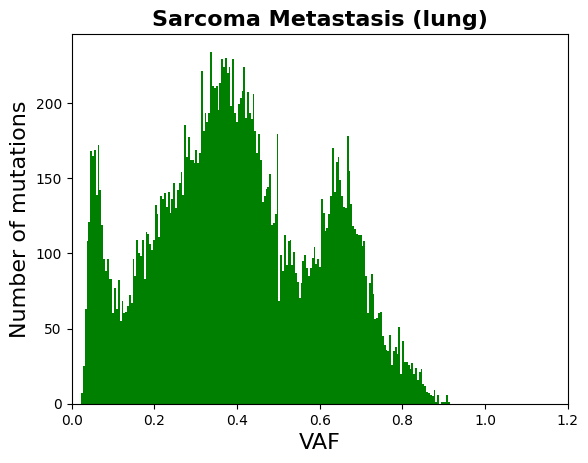

In [21]:
# VAF representation through histogram
plt.hist(final_mutations_df['VAF'].tolist(), bins = 200, color = "green")
plt.ylabel('Number of mutations', fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Metastasis (lung)',fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(final_mutations_df['VAF'].tolist()) 

### Change Graph language for master project

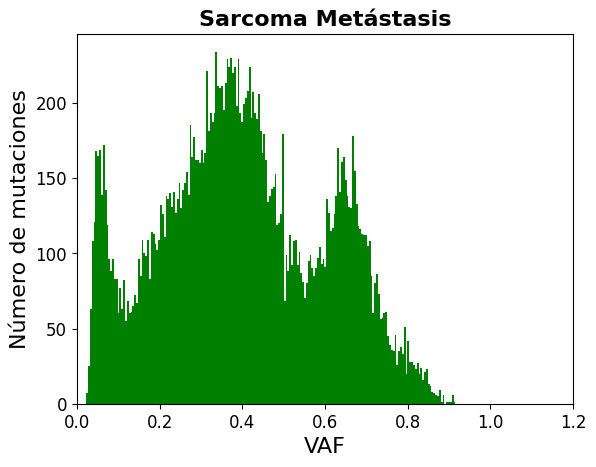

In [23]:
# VAF representation through histogram
plt.hist(final_mutations_df['VAF'].tolist(), bins = 200, color = "green")
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Metástasis',fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show(final_mutations_df['VAF'].tolist()) 